# Instrument recognition in musical audio signals
Group 2: Jakob Dittrich, Lea Franz, David Reiter, Thomas Sickinger

## Setup

In [79]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from os import listdir
import librosa.display
import pickle

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import recall_score, precision_score, accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

# color for plots
pltcolor = '#002b36'
plt.rcParams['figure.figsize'] = [16, 9]

In [80]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=Warning)

## Data

The training data contains 6705 audio files in 16 bit stereo wav format sampled at 44.1kHz. They are excerpts of 3 seconds from more than 2000 distinct recordings. The number of files per instrument are: cello (388), clarinet (505), flute (451), acoustic guitar (637), electric guitar (760), organ (682), piano (721), saxophone (626), trumpet (577), violin (580), human voice (778).


The test data contains 2874 excerpts in 16 bit stereo wav format sampled at 44.1kHz.

Source: https://www.upf.edu/web/mtg/irmas

### Loading the data
For loading the audio data we use **librosa**. This is python package for music and audio analysis. It provides the building blocks necessary to create music information retrieval systems. In this project it is used for loading .wav files,  extracting features and visualizations.

## Analysis of data

### Instrument class balance

In [81]:
class_dirs = os.listdir('./IRMAS-TrainingData/')
#class_dirs.remove('.DS_Store')
#class_dirs.remove('README.txt')
class_dirs

['pia',
 'voi',
 '.DS_Store',
 'tru',
 'sax',
 'org',
 'cla',
 'gac',
 'vio',
 'flu',
 'README.txt',
 'gel',
 'cel']

This project uses the following instruments: 

In [82]:
Instruments = sorted(['vio', 'pia', 'org', 'gel', 'gac', 'voi'])
Instruments

['gac', 'gel', 'org', 'pia', 'vio', 'voi']

The plot shows that the the numbers of samples per instrument are not balanced. The instrument with the most samples is **voi** and the instrument with the least samples is **vio**.

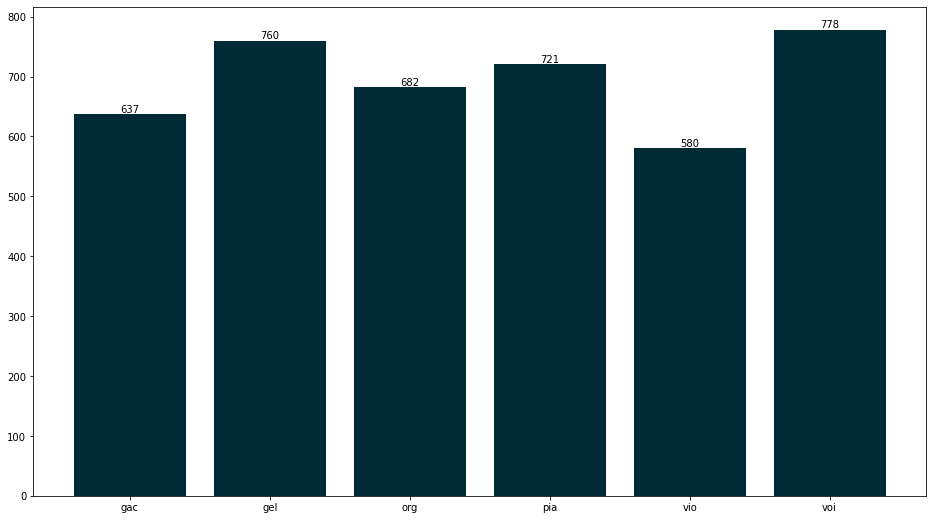

In [83]:
number_of_files = []
for class_name in Instruments:
    class_dir = os.listdir('./IRMAS-TrainingData/'+class_name)
    number_of_files.append(len(class_dir))

fig, ax = plt.subplots()
bars = ax.bar(Instruments, number_of_files, color=pltcolor);
ax.bar_label(bars);

### Example file

In [84]:
y , sr = librosa.load('./IRMAS-TrainingData/cel/008__[cel][nod][cla]0058__1.wav')

**Waveform in the time domain**

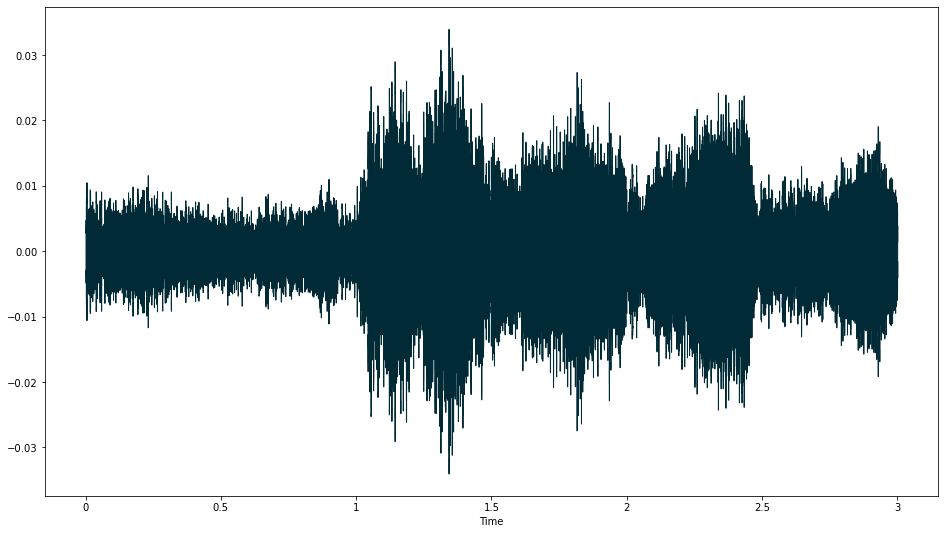

In [85]:
librosa.display.waveshow(y, sr=sr, color=pltcolor);

**Spectrogram**

A spectrogram is the visual representation of the spectrum of frequencies of a signal over time.

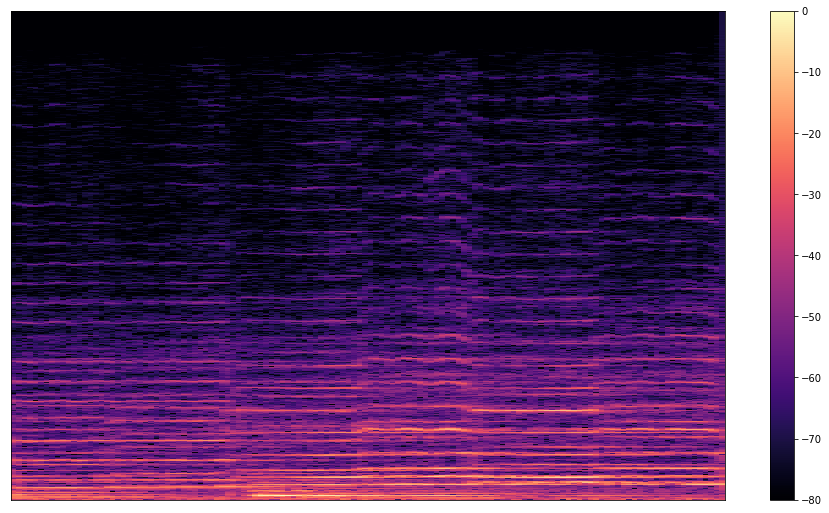

In [86]:
stft = librosa.stft(y)  # short time fourier transform
magnitudes_to_decibel = librosa.amplitude_to_db(np.abs(stft), ref=np.max) # mapping magnitudes to decibel scale

plt.figure()
librosa.display.specshow(magnitudes_to_decibel)
plt.colorbar();

## Feature extraction

**Zero Crossing Rate:** the rate at which the signal crosses zero

**Spectral Centroid:** the center of mass in the spectrum

**Spectral Bandwidth:** the weighted average of the frequency signal by its spectrum

**Spectral Roll-Off:** frequency below which a specified percentage of the total spectral energy

In [87]:
header = 'filename rms spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21): # TODO why 21?
    header += f' mfcc{i}'
header += ' label'
header = header.split()

Creating a .csv file for storing the data from the music files as extracted features

In [88]:


csv_exists = True

if csv_exists == False:
    file = open('data.csv', 'w', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(header)



In [89]:


if csv_exists == False:
    file = open('data.csv', 'w', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(header)
    
    for i in Instruments:
        for filename in os.listdir(f'./IRMAS-TrainingData/{i}'):
            songname = f'./IRMAS-TrainingData/{i}/{filename}'
            y, sr = librosa.load(songname, sr =44100)
            rms = librosa.feature.rms(y=y)
            spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
            spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
            rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
            zcr = librosa.feature.zero_crossing_rate(y)
            mfcc = librosa.feature.mfcc(y=y, sr=sr)
            to_append = f'{filename} {np.mean(rms)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
            for e in mfcc:
                to_append += f' {np.mean(e)}'
            to_append += f' {i}'
            file = open('data.csv', 'a', newline='')
            with file:
                writer = csv.writer(file)
                writer.writerow(to_append.split())

In [90]:
df = pd.read_csv('data.csv')
df.head()


,filename,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,[vio][jaz_blu]2092__2.wav,0.114771,2008.963579,3413.310309,4315.952280,0.026062,-238.207855,147.416168,19.073757,37.603371,...,8.651993,-2.919450,6.087282,1.375321,3.519054,4.003036,8.993670,14.583170,15.063288,vio
1,[vio][pop_roc]2247__2.wav,0.045145,1904.285733,2847.219346,3232.807221,0.043721,-355.952362,147.138260,-6.634732,24.655594,...,6.055483,-4.204406,11.720703,1.755819,0.502440,-10.289815,-3.562097,-3.135212,-6.306681,vio
2,027__[vio][dru][cou_fol]2189__2.wav,0.257842,3759.639612,3539.671618,7444.252798,0.118622,-37.659492,123.618378,-55.597813,66.752762,...,9.085865,-0.278380,5.583296,1.927523,0.012852,2.059954,-10.427495,-0.631917,-4.914731,vio
3,[vio][cla]2087__1.wav,0.003137,2511.258695,2752.212704,4338.400021,0.068420,-537.393799,126.677574,-69.857018,21.041725,...,-0.073176,-2.393554,19.921106,16.488857,9.842477,1.030309,-4.826866,-4.345613,-0.308287,vio
4,099__[vio][nod][cla]2172__1.wav,0.031447,958.535672,1431.991046,1768.383129,0.021094,-431.933594,203.627762,-24.785480,29.247166,...,-2.118557,-11.496170,-2.753783,1.015238,-1.763513,-3.037489,0.608210,5.419205,-1.962356,vio


## Analysis of features

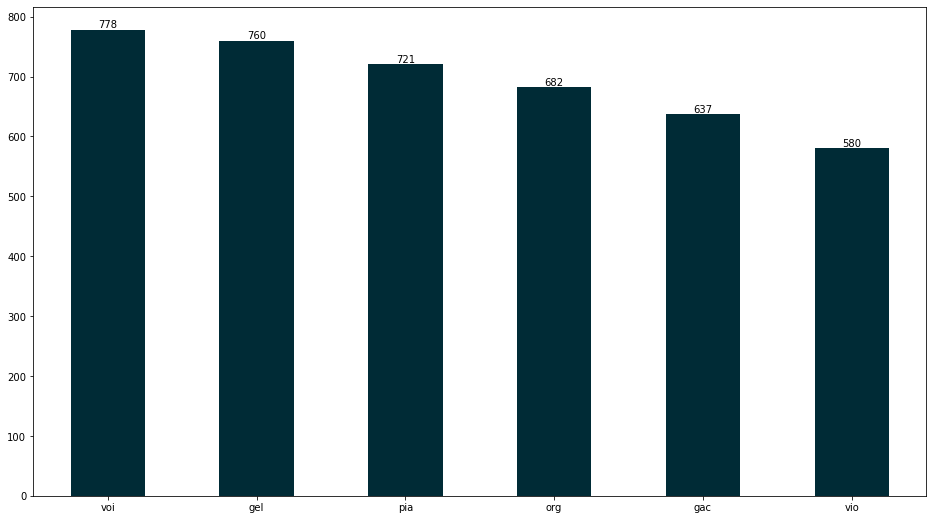

In [91]:
table = df['label'].value_counts()
ax = table.plot(kind='bar', rot=0, color=pltcolor);
ax.bar_label(ax.containers[0]);

The class imbalance and the number of samples per instrument are still the same after the feature extraction.

### Correlation between features

The most correlated features are rolloff and spectral_centroid, spectral bandwith and rolloff as well as spectral_centroid and spectral_bandwidth.

In [92]:
df_corr = df
df_corr.corr().unstack().sort_values().drop_duplicates()

mfcc2               spectral_centroid    -0.832009
spectral_bandwidth  mfcc2                -0.820206
rolloff             mfcc2                -0.774466
mfcc2               mfcc4                -0.645317
mfcc6               mfcc2                -0.598631
                                            ...   
spectral_centroid   zero_crossing_rate    0.863322
                    spectral_bandwidth    0.900877
spectral_bandwidth  rolloff               0.932395
spectral_centroid   rolloff               0.965179
rms                 rms                   1.000000
Length: 301, dtype: float64

Highest correlation of 0.967746 between spectral_centroid and rolloff

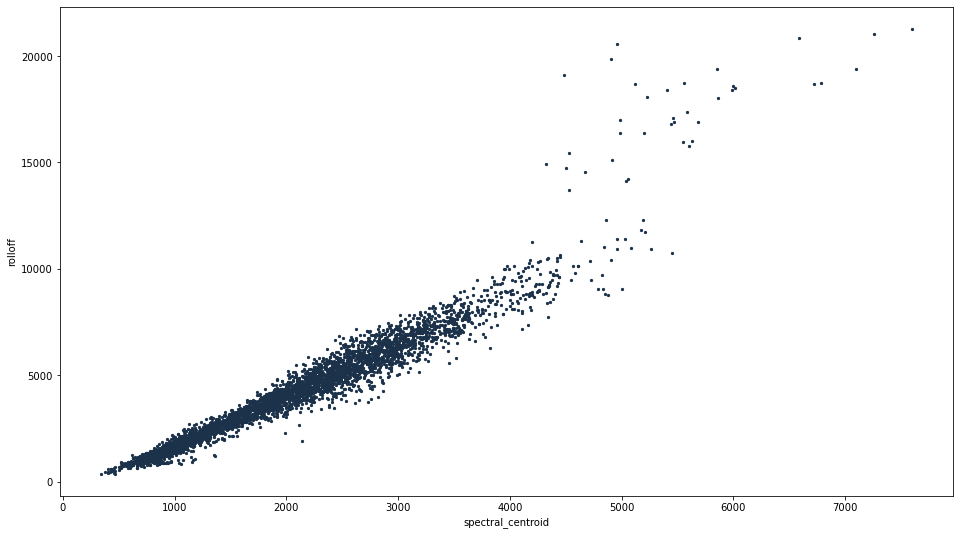

In [93]:
df.plot.scatter("spectral_centroid", "rolloff", c="#1b324a", marker='.');

## Preprocessing

### NaN values

In [94]:
df.isnull().values.any()

False

There are no NaN values in this dataset.

### Outliers

In [95]:
cols = df.columns.tolist()
cols.remove('label')
cols.remove('filename')

for col in cols:
    q25 = df[col].quantile(0.25)
    q75 = df[col].quantile(0.75)
    intr_qr = q75-q25

    q_hi = q75+(1.5*intr_qr)
    q_low = q25-(1.5*intr_qr)

    df_filtered = df[(df[col] < q_hi) & (df[col] > q_low)]

print(str(len(df)-len(df_filtered))+' rows with outliers removed.')
df = df_filtered


90 rows with outliers removed.


### Scaling

In [96]:
# drop filename from dataframe
df = df.drop(['filename'],axis=1)

In [97]:
# extract instrument labels
instru_list = df.iloc[:, -1]
encoder = LabelEncoder()

# encode labels to numeric values
y = encoder.fit_transform(instru_list)
labels = y

df['label'] = y

# uniformly scale data
scaler = StandardScaler()
X_transform = scaler.fit_transform(df.iloc[:, :-1].values)

# save scaler
pickle.dump(scaler, open('./scaler.pkl','wb'))

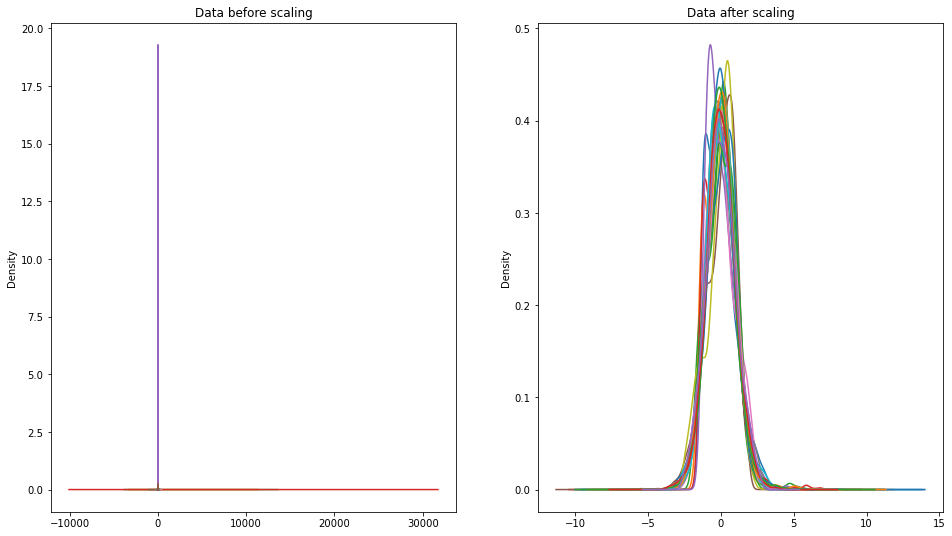

In [98]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.set_title("Data before scaling")
ax2.set_title("Data after scaling")

df.plot.density(ax=ax1, legend=False);
df_scaled = pd.DataFrame(X_transform, columns=df.iloc[:, :-1].columns)
df_scaled.plot.density(ax=ax2, legend=False);

In [99]:
# print labels
print('Numberic values instead of class names: ')
print(y)

Numberic values instead of class names: 
[4 4 4 ... 5 5 5]


### Features

The main feature extraction was already done by extracting the features from the .wav files.

#### Feature reduction with PCA

This plot shows the explained variance ratio when 95% of variance is kept.    
Feature reduction with PCA  wil be applied later when training the models using a pipeline.

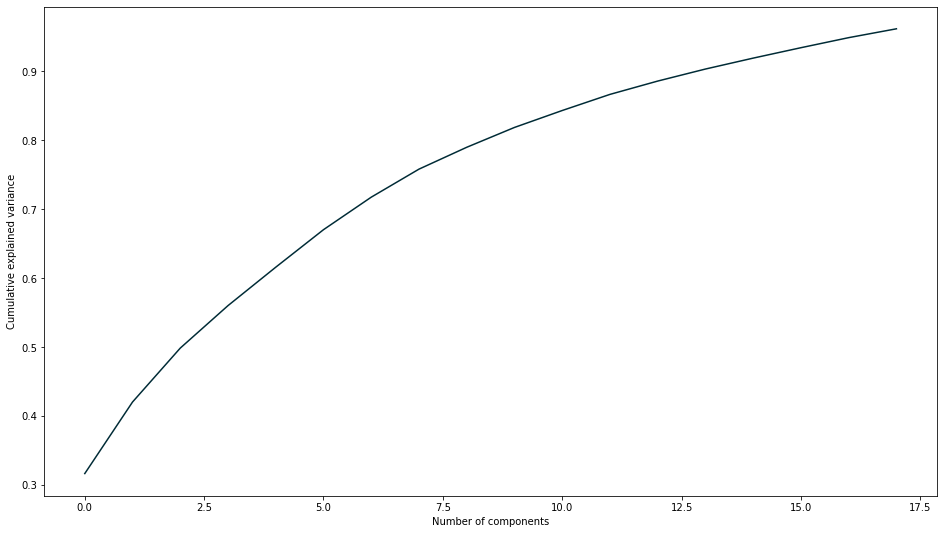

In [100]:
pca = PCA(n_components=0.95)
X_pca = pca.fit(X_transform)
plt.plot(np.cumsum(pca.explained_variance_ratio_), color=pltcolor)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()


PCA with 95% variance means 18 components in this case.

In [101]:
X_pca = pca.transform(X_transform)
X_pca.shape

(4068, 18)

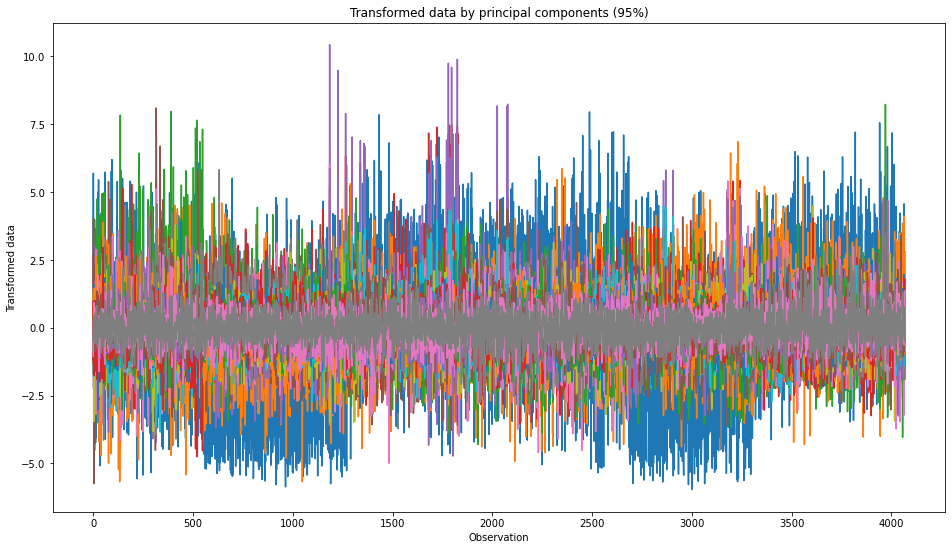

In [102]:
plt.plot(X_pca)
plt.xlabel('Observation')
plt.ylabel('Transformed data')
plt.title('Transformed data by principal components (95%)');

## Models

In [103]:
# shuffle dataframe
df1 = shuffle(df)
df1.head()

,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
3466,0.198290,2977.717919,3423.024835,6255.769637,0.069091,-90.755875,148.475204,-38.050159,47.958862,-18.078278,...,11.183619,-15.296259,-0.384890,3.475727,-5.454670,2.602835,-2.135927,1.591296,-8.192727,5
1799,0.223300,3157.771551,3585.654101,7000.702069,0.078080,-57.832249,150.303070,-48.936592,38.633545,-25.750053,...,2.352964,4.249008,-0.455750,2.101110,-9.369297,-1.760077,-9.958668,1.625136,-2.414784,2
1753,0.111118,3817.851531,3711.275231,8461.135452,0.100799,-180.239594,107.066078,-38.866535,51.327385,-22.388268,...,6.372686,14.016374,8.460157,11.307698,-5.853026,-7.395549,-5.854128,1.432955,-5.708203,2
2317,0.202203,2911.883954,3063.133144,5862.684755,0.074554,-80.786682,143.677856,-56.609280,65.475868,-9.645350,...,-3.107792,6.081706,5.545217,12.510855,-1.262690,8.691004,0.182059,3.478272,-3.604869,1
2061,0.333664,2566.015317,2736.724069,5181.271115,0.065760,-30.099115,170.829529,-68.913071,49.026634,-22.767323,...,3.974048,3.366337,-5.192389,-2.249304,-8.350615,0.707006,-6.011970,1.875583,-6.105858,1


Test data with all features

In [104]:
# split dataset in train and test data
X_train, X_test, y_train, y_test = train_test_split(X_transform, y, test_size=0.2)

### SVM Model

In [105]:
tuning_params_svm={"C": [0.001, 0.01, 0.1, 1, 10], "gamma": [0.001, 0.01, 0.1, 1, 10], "kernel": ['rbf']}
param_grid_svm = {}

for key,value in tuning_params_svm.items():
    hyperparam_key = "classify__" + key
    param_grid_svm[hyperparam_key] = value

In [106]:
pipe = Pipeline([
        ('classify', SVC())
])

gs = GridSearchCV(pipe, param_grid=param_grid_svm, cv=10, scoring="balanced_accuracy")
gs.fit(X_train, y_train);

In [107]:
print('Best parameters: '+str(gs.best_params_))
print('Best balanced accuracy score: '+str(gs.best_score_))

Best parameters: {'classify__C': 10, 'classify__gamma': 0.1, 'classify__kernel': 'rbf'}
Best balanced accuracy score: 0.757835493646214


Recall:  [0.825      0.75177305 0.84210526 0.82394366 0.70689655 0.69230769]
Recall Average:  0.7751842751842751
Precision:  [0.76153846 0.72108844 0.80503145 0.82978723 0.73873874 0.78571429]
Precision Average:  0.7751842751842751
F1-Score:  [0.792      0.73611111 0.82315113 0.82685512 0.72246696 0.73605948]
Balanced Accuracy: 0.77  , 0.7736710364678244
Accuracy: 0.78  , 631
Number of samples: 814


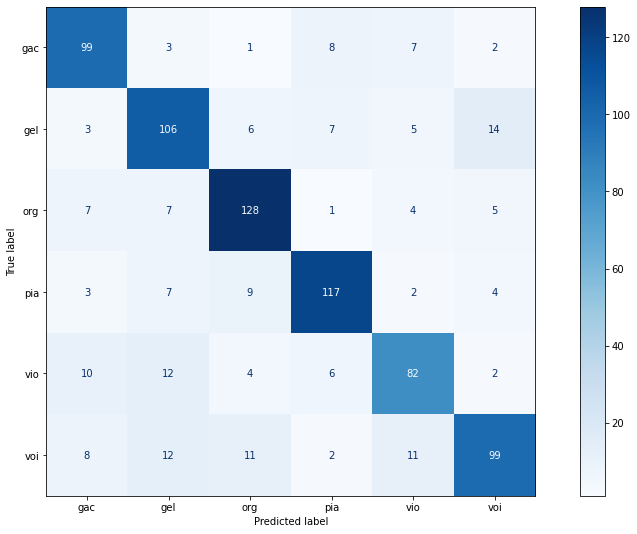

In [108]:
predicted_labels = gs.best_estimator_.predict(X_test)
predicted_labels_svm = predicted_labels

svm_model = gs.best_estimator_

# save model
pickle.dump(svm_model, open('./model.pkl', 'wb'))


print("Recall: ", recall_score(y_test, predicted_labels,average=None))
print("Recall Average: ", recall_score(y_test, predicted_labels,average="micro"))
print("Precision: ", precision_score(y_test, predicted_labels,average=None))
print("Precision Average: ", precision_score(y_test, predicted_labels,average="micro"))
print("F1-Score: ", f1_score(y_test, predicted_labels, average=None))
print("Balanced Accuracy: %.2f  ," % balanced_accuracy_score(y_test, predicted_labels), balanced_accuracy_score(y_test, predicted_labels) )
print("Accuracy: %.2f  ," % accuracy_score(y_test, predicted_labels,normalize=True), accuracy_score(y_test, predicted_labels,normalize=False) )

print("Number of samples:",y_test.shape[0])
ConfusionMatrixDisplay(confusion_matrix(y_test, predicted_labels), display_labels=Instruments).plot(cmap="Blues");


### KNN

In [109]:
knn = KNeighborsClassifier()
param_grid = dict(n_neighbors=list(range(1, 31)))
  
# defining parameter range
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, scoring='balanced_accuracy', return_train_score=False,verbose=1)
  
# fitting the model for grid search
grid_search=grid.fit(X_train, y_train)

accuracy = grid_search.best_score_ *100
print("Best params: "+str(grid_search.best_params_))
print("Balanced accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best params: {'n_neighbors': 1}
Balanced accuracy for our training dataset with tuning is : 74.87%


Recall:  [0.80833333 0.75177305 0.86184211 0.83098592 0.67241379 0.78321678]
Recall Average:  0.7886977886977887
Precision:  [0.79508197 0.78518519 0.83974359 0.72392638 0.75728155 0.82962963]
Precision Average:  0.7886977886977887
F1-Score:  [0.80165289 0.76811594 0.85064935 0.77377049 0.71232877 0.8057554 ]
Accuracy: 0.79  , 642
Balanced accuracy: 0.78  , 0.7847608300091785
Number of samples: 814


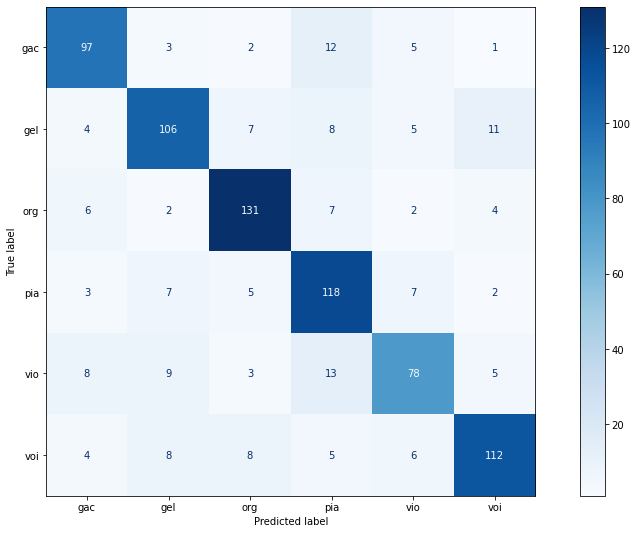

In [110]:
predicted_labels = grid.best_estimator_.predict(X_test)

print("Recall: ", recall_score(y_test, predicted_labels,average=None))
print("Recall Average: ", recall_score(y_test, predicted_labels,average="micro"))
print("Precision: ", precision_score(y_test, predicted_labels,average=None))
print("Precision Average: ", precision_score(y_test, predicted_labels,average="micro"))
print("F1-Score: ", f1_score(y_test, predicted_labels, average=None))
print("Accuracy: %.2f  ," % accuracy_score(y_test, predicted_labels,normalize=True), accuracy_score(y_test, predicted_labels,normalize=False) )
print("Balanced accuracy: %.2f  ," % balanced_accuracy_score(y_test, predicted_labels), balanced_accuracy_score(y_test, predicted_labels) )

print("Number of samples:",y_test.shape[0])
ConfusionMatrixDisplay(confusion_matrix(y_test, predicted_labels), display_labels=Instruments).plot(cmap="Blues");


### Logistic Regression

In [111]:
tuning_params_logr={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
param_grid_logr = {}

for key,value in tuning_params_logr.items():
    hyperparam_key = "classify__" + key
    param_grid_logr[hyperparam_key] = value

In [112]:
pipe = Pipeline([
        ('classify', LogisticRegression())
])

gs = GridSearchCV(pipe, param_grid=param_grid_logr, cv=10, scoring="balanced_accuracy")
gs.fit(X_train, y_train);

In [113]:
print('Best parameters: '+str(gs.best_params_))
print('Best balanced accuracy score: '+str(gs.best_score_))

Best parameters: {'classify__C': 100.0, 'classify__penalty': 'l2'}
Best balanced accuracy score: 0.541491973387213


Recall:  [0.56666667 0.41843972 0.57894737 0.73239437 0.47413793 0.5034965 ]
Recall Average:  0.547911547911548
Precision:  [0.53125    0.42753623 0.51461988 0.65408805 0.6547619  0.53731343]
Precision Average:  0.547911547911548
F1-Score:  [0.5483871  0.42293907 0.54489164 0.6910299  0.55       0.5198556 ]
Accuracy: 0.55  , 446
Balanced accuracy: 0.55  , 0.5456804253546576
Number of samples: 814


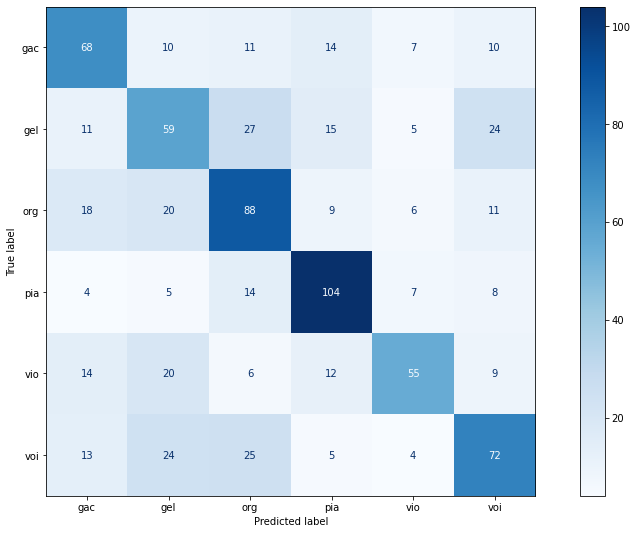

In [114]:
predicted_labels = gs.best_estimator_.predict(X_test)

print("Recall: ", recall_score(y_test, predicted_labels,average=None))
print("Recall Average: ", recall_score(y_test, predicted_labels,average="micro"))
print("Precision: ", precision_score(y_test, predicted_labels,average=None))
print("Precision Average: ", precision_score(y_test, predicted_labels,average="micro"))
print("F1-Score: ", f1_score(y_test, predicted_labels, average=None))
print("Accuracy: %.2f  ," % accuracy_score(y_test, predicted_labels,normalize=True), accuracy_score(y_test, predicted_labels,normalize=False) )
print("Balanced accuracy: %.2f  ," % balanced_accuracy_score(y_test, predicted_labels), balanced_accuracy_score(y_test, predicted_labels) )

print("Number of samples:",y_test.shape[0])
ConfusionMatrixDisplay(confusion_matrix(y_test, predicted_labels), display_labels=Instruments).plot(cmap="Blues");


## Evaluation with PCA

In [115]:
# Initialze the estimators
clf1 = SVC()
clf2 = KNeighborsClassifier()
clf3 = LogisticRegression()

In [116]:
# hyperparameters for each dictionary
param1 = {}
param1['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]
param1['classifier__gamma'] = [0.001, 0.01, 0.1, 1, 10]
param1['classifier__kernel'] = ['rbf']
param1['classifier'] = [clf1]

param2 = {}
param2['classifier__n_neighbors'] = list(range(1, 31))
param2['classifier'] = [clf2]

param3 = {}
param3['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]
param3['classifier__penalty'] = ['l1', 'l2']
param3['classifier'] = [clf3]



In [117]:
# pipeline = Pipeline([('classifier', clf1)])
pipe = Pipeline([
        ('normalization', StandardScaler()),
        ('pca', PCA(n_components=0.95)), 
        ('classifier', clf1)
])
params = [param1, param2, param3]

In [118]:
# pca grid search
gs_pca = GridSearchCV(pipe, params, cv=10, scoring='balanced_accuracy').fit(X_train, y_train)


In [119]:
print('Best classifier and parameters: '+str(gs_pca.best_params_))
print('Best balanced accuracy score: '+str(gs_pca.best_score_))
print('Best estimator explained variance: '+str(gs_pca.best_estimator_.steps[1][1].explained_variance_))

Best classifier and parameters: {'classifier': SVC(C=10, gamma=0.1), 'classifier__C': 10, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'}
Best balanced accuracy score: 0.7231537123159366
Best estimator explained variance: [7.96079254 2.62606033 1.96360092 1.53741348 1.35367879 1.33718995
 1.17596696 1.01777652 0.79451513 0.71290361 0.61980229 0.5734378
 0.48166839 0.42597367 0.39869405 0.37629175 0.36561756 0.31626413]


Recall:  [0.80833333 0.72340426 0.80921053 0.76760563 0.6637931  0.68531469]
Recall Average:  0.7444717444717445
Precision:  [0.69285714 0.70344828 0.77848101 0.78985507 0.72641509 0.77165354]
Precision Average:  0.7444717444717445
F1-Score:  [0.74615385 0.71328671 0.79354839 0.77857143 0.69369369 0.72592593]
Balanced Accuracy: 0.74  , 0.7429435895890083
Accuracy: 0.74  , 606
Number of samples: 814


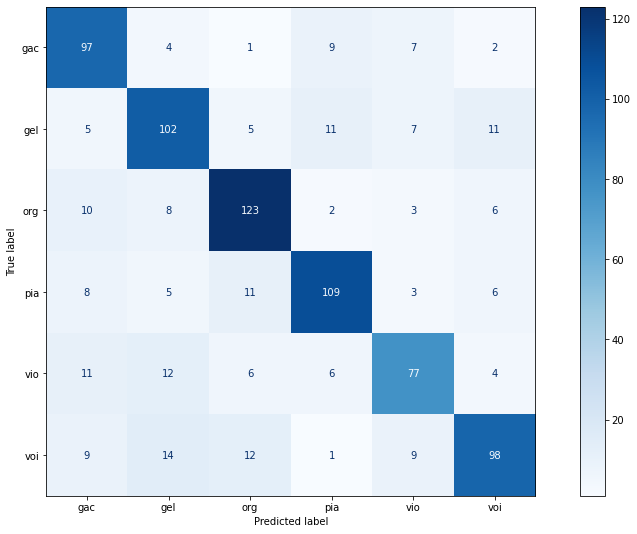

In [120]:
predicted_labels_pca = gs_pca.best_estimator_.predict(X_test)

print("Recall: ", recall_score(y_test, predicted_labels_pca,average=None))
print("Recall Average: ", recall_score(y_test, predicted_labels_pca,average="micro"))
print("Precision: ", precision_score(y_test, predicted_labels_pca,average=None))
print("Precision Average: ", precision_score(y_test, predicted_labels_pca,average="micro"))
print("F1-Score: ", f1_score(y_test, predicted_labels_pca, average=None))
print("Balanced Accuracy: %.2f  ," % balanced_accuracy_score(y_test, predicted_labels_pca), balanced_accuracy_score(y_test, predicted_labels_pca) )
print("Accuracy: %.2f  ," % accuracy_score(y_test, predicted_labels_pca,normalize=True), accuracy_score(y_test, predicted_labels_pca,normalize=False) )

print("Number of samples:",y_test.shape[0])
ConfusionMatrixDisplay(confusion_matrix(y_test, predicted_labels_pca), display_labels=Instruments).plot(cmap="Blues");

## Conclusion

which instrument the best

explanation which model

Best overall model so far: SVM with all features

In [121]:
print('Recall')
rec_score = recall_score(y_test, predicted_labels_svm,average=None)
for idx, inst in enumerate(Instruments):
    print(inst+': '+str(rec_score[idx]))
print()
print('Precision')
rec_score = precision_score(y_test, predicted_labels_svm,average=None)
for idx, inst in enumerate(Instruments):
    print(inst+': '+str(rec_score[idx]))


Recall
gac: 0.825
gel: 0.75177304964539
org: 0.8421052631578947
pia: 0.823943661971831
vio: 0.7068965517241379
voi: 0.6923076923076923

Precision
gac: 0.7615384615384615
gel: 0.7210884353741497
org: 0.8050314465408805
pia: 0.8297872340425532
vio: 0.7387387387387387
voi: 0.7857142857142857


In [122]:
def predict_instrument(filename):

    # load model
    #svm_model = pickle.load(open('./model.pkl', 'rb'))

    # load scaler
    #scaler = pickle.load(open('./scaler.pkl','rb'))

    y, sr = librosa.load(filename, sr =44100)
    rms = librosa.feature.rms(y=y)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)

    columns = ['rms', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate']
    for i in range(len(mfcc)):
        columns.append('mfcc' + str(i+1))

    rows = [np.mean(rms), np.mean(spec_cent), np.mean(spec_bw), np.mean(rolloff), np.mean(zcr)]

    for i in mfcc:
        rows.append(np.mean(i))
    
    # create dataframe
    df_test = pd.DataFrame([rows])
    df_test.columns = columns

    # uniformly scale data
    test_transform = scaler.transform(df_test.values)

    return svm_model.predict(test_transform)
    

In [123]:
file_name = './IRMAS-TrainingData/voi/033__[voi][nod][pop_roc]2467__1.wav'    
result = predict_instrument(file_name)

Instruments[result[0]]

'voi'

In [124]:
file_name = './IRMAS-TrainingData/vio/099__[vio][nod][cla]2172__1.wav'    
result = predict_instrument(file_name)

Instruments[result[0]]

'vio'

In [125]:
file_name = './IRMAS-TrainingData/gac/040__[gac][nod][cou_fol]0713__2.wav'    
result = predict_instrument(file_name)

Instruments[result[0]]

'gac'

In [126]:
file_name = './IRMAS-TrainingData/gel/251__[gel][dru][pop_roc]0833__2.wav'    
result = predict_instrument(file_name)

Instruments[result[0]]

'gel'

In [ ]:
file_name = './IRMAS-TestingData-Part1/Part1/00 - gold fronts-12.wav'    
result = predict_instrument(file_name)

Instruments[result[0]]